In [ ]:
!pip install torch_geometric
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 661.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata 

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData

# 데이터 로드 및 전처리
users = pd.read_csv('/dataset/chunk10/non_fraud_user.csv')
users_fraud = pd.read_csv('/dataset/chunk10/fraud_user.csv')
users = pd.concat([users, users_fraud], ignore_index=True)

merchants = pd.read_csv('/dataset/chunk10/non_fraud_merchant.csv')
merchants_fraud = pd.read_csv('/dataset/chunk10/fraud_merchant.csv')
merchants = pd.concat([merchants, merchants_fraud], ignore_index=True)

non_fraud_transactions = pd.read_csv('/dataset/chunk10/non_fraud_transaction.csv')
fraud_transactions = pd.read_csv('/dataset/chunk10/non_fraud_transaction.csv')
transactions = pd.concat([non_fraud_transactions, fraud_transactions], ignore_index=True)



#HeteroData 객체 생성
data = HeteroData()

#사용자 노드 추가(+feature)
data['user'].x=torch.tensor(users[['User']].values, dtype=torch.float)
data['user'].card = torch.tensor(users[['Card']].values, dtype=torch.float)
data['user'].chip = torch.tensor(users[['Use Chip']].values, dtype=torch.float)

#판매자 노드 추가(+feature)
data['merchant'].x=torch.tensor(merchants[['Merchant Name']].values, dtype=torch.float)
data['merchant'].city = torch.tensor(merchants[['Merchant City']].values, dtype=torch.float)
data['merchant'].mcc = torch.tensor(merchants[['MCC']].values, dtype=torch.float)

# 엣지 추가
user_ids = transactions['User'].values
merchant_ids = transactions['Merchant Name'].values

edge_index = torch.tensor([user_ids, merchant_ids], dtype=torch.long)
data['user', 'transaction', 'merchant'].edge_index = edge_index

# 역방향 엣지 추가
reverse_edge_index = torch.tensor([merchant_ids, user_ids], dtype=torch.long)
reverse_edge_index = reverse_edge_index[:, :edge_index.size(1)]
data['merchant', 'reverse_transaction', 'user'].edge_index = reverse_edge_index

# 엣지 특성 추가 (개수를 맞추기 위해 transactions 데이터프레임을 사용)
data['user', 'transaction', 'merchant'].amount = torch.tensor(transactions['Amount'].values[:len(edge_index[0])], dtype=torch.float)
data['user', 'transaction', 'merchant'].fraud = torch.tensor(transactions['Is Fraud?'].values[:len(edge_index[0])], dtype=torch.float)
data['user', 'transaction', 'merchant'].time = torch.tensor(transactions['Datetime_As_Float'].values[:len(edge_index[0])], dtype=torch.float)

# 역방향 엣지에도 동일한 특성 추가
data['merchant', 'reverse_transaction', 'user'].amount = torch.tensor(transactions['Amount'].values[:len(reverse_edge_index[0])], dtype=torch.float)
data['merchant', 'reverse_transaction', 'user'].fraud = torch.tensor(transactions['Is Fraud?'].values[:len(reverse_edge_index[0])], dtype=torch.float)
data['merchant', 'reverse_transaction', 'user'].time = torch.tensor(transactions['Datetime_As_Float'].values[:len(reverse_edge_index[0])], dtype=torch.float)


HeteroData(
  user={
    x=[2438690, 1],
    card=[2438690, 1],
    chip=[2438690, 1],
  },
  merchant={
    x=[2438690, 1],
    city=[2438690, 1],
    mcc=[2438690, 1],
  },
  (user, transaction, merchant)={
    edge_index=[2, 2438690],
    amount=[2438690],
    fraud=[2438690],
    time=[2438690],
  },
  (merchant, reverse_transaction, user)={
    edge_index=[2, 2438690],
    amount=[2438690],
    fraud=[2438690],
    time=[2438690],
  }
)


In [ ]:
from torch_geometric.loader import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

# 전체 트랜잭션 인덱스 얻기
total_indices = transactions.index

# 70% 지점 계산
# 데이터를 위에서부터 7:3 으로 나눠서 7은 학습 3은 테스트 데이터로 구성했습니다.
split_point = int(len(total_indices) * 0.7)

# 순차적으로 데이터 분할
train_indices = total_indices[:split_point]
test_indices = total_indices[split_point:]

# edge_index
edge_index = data['user', 'transaction', 'merchant'].edge_index
train_edge_index = edge_index[:, :split_point]
test_edge_index = edge_index[:, split_point:]

# 학습 데이터 구성
# Edge
# 제 생각에는 학습할 때 edge_index 만 반영이 되고 그래프 특징들이 반영이 안되는 것 같아서 edge_attr를 따로 추가해줬습니다
# 그리고 학습할 때 is_fraud 를 같이 속성으로 주면 답을 주는 거니까 안되는 것 같아서 밑에 따로 라벨링 해서 넣어줬습니다(확실x)
train_data = data.clone()
train_data['user', 'transaction', 'merchant'].edge_index = train_edge_index
train_data['user', 'transaction', 'merchant'].edge_attr = torch.tensor(transactions.loc[train_indices, ['Amount', 'Datetime_As_Float']].values, dtype=torch.float)
train_data['merchant', 'reverse_transaction', 'user'].edge_index = train_edge_index
train_data['merchant', 'reverse_transaction', 'user'].edge_attr = torch.tensor(transactions.loc[train_indices, ['Amount', 'Datetime_As_Float']].values, dtype=torch.float)

test_data = data.clone()
test_data['user', 'transaction', 'merchant'].edge_index = test_edge_index
test_data['user', 'transaction', 'merchant'].edge_attr = test_edge_attr = torch.tensor(transactions.loc[test_indices, ['Amount', 'Datetime_As_Float']].values, dtype=torch.float)
test_data['merchant', 'reverse_transaction', 'user'].edge_index = test_edge_index
test_data['merchant', 'reverse_transaction', 'user'].edge_attr = test_edge_attr = torch.tensor(transactions.loc[test_indices, ['Amount', 'Datetime_As_Float']].values, dtype=torch.float)

# User Node
# users,merchant 노드도 .x 만 반영이 되고 나머지 card, chip 등 특징들은 반영이 안되고 있는 것 같습니다.(확실x) 따로 추가는 안했습니다.
train_user_features = users.loc[train_indices]
test_user_features = users.loc[test_indices]

train_data['user'].x = torch.tensor(train_user_features[['User']].values, dtype=torch.float)
train_data['user'].card = torch.tensor(train_user_features[['Card']].values, dtype=torch.float)
train_data['user'].chip = torch.tensor(train_user_features[['Use Chip']].values, dtype=torch.float)

test_data['user'].x = torch.tensor(test_user_features[['User']].values, dtype=torch.float)
test_data['user'].card = torch.tensor(test_user_features[['Card']].values, dtype=torch.float)
test_data['user'].chip = torch.tensor(test_user_features[['Use Chip']].values, dtype=torch.float)


# Merchant Node
train_merchant_features = merchants.loc[train_indices]
test_merchant_features = merchants.loc[test_indices]

train_data['merchant'].x = torch.tensor(train_merchant_features[['Merchant Name']].values, dtype=torch.float)
train_data['merchant'].city = torch.tensor(train_merchant_features[['Merchant City']].values, dtype=torch.float)
train_data['merchant'].mcc = torch.tensor(train_merchant_features[['MCC']].values, dtype=torch.float)

train_data['merchant'].x = torch.tensor(train_merchant_features[['Merchant Name']].values, dtype=torch.float)
train_data['merchant'].city = torch.tensor(train_merchant_features[['Merchant City']].values, dtype=torch.float)
train_data['merchant'].mcc = torch.tensor(train_merchant_features[['MCC']].values, dtype=torch.float)

# 위에서 말했던 is_fraud 따로 라벨링하는 부분입니다. 밑에 학습 코드에서 넣어줍니다.
train_labels = torch.tensor(transactions.loc[train_indices, 'Is Fraud?'].values, dtype=torch.float)
test_labels = torch.tensor(transactions.loc[test_indices, 'Is Fraud?'].values, dtype=torch.float)

# 데이터 로더
train_loader = DataLoader([train_data], batch_size=1, shuffle=False)
test_loader = DataLoader([test_data], batch_size=1, shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler

class CustomConv(MessagePassing):
    def __init__(self, edge_attr_dim, out_channels, dropout_rate=0.3):
        super().__init__(aggr='mean')
        self.lin = torch.nn.Linear(edge_attr_dim, out_channels)
        self.dropout = torch.nn.Dropout(dropout_rate)  # Dropout 추가

    def forward(self, edge_index, edge_attr):
        return self.propagate(edge_index, edge_attr=edge_attr)

    def message(self, edge_attr):
        x = self.lin(edge_attr)
        return self.dropout(x)  # Dropout 적용


class GNN(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        edge_attr_dim = 2

        self.conv1_user_to_merchant = CustomConv(edge_attr_dim, 128, dropout_rate)
        self.bn1 = torch.nn.BatchNorm1d(128)

        self.conv1_merchant_to_user = CustomConv(edge_attr_dim, 128, dropout_rate)
        self.bn2 = torch.nn.BatchNorm1d(128)

        self.conv2_user_to_merchant = CustomConv(edge_attr_dim, 128, dropout_rate)
        self.bn3 = torch.nn.BatchNorm1d(128)

        self.conv2_merchant_to_user = CustomConv(edge_attr_dim, 128, dropout_rate)
        self.bn4 = torch.nn.BatchNorm1d(128)

        self.linear = torch.nn.Linear(128, 1)

    def forward(self, edge_index_user_to_merchant, edge_index_merchant_to_user, edge_attr_user_to_merchant, edge_attr_merchant_to_user):
        x_merchant = F.relu(self.conv1_user_to_merchant(edge_index_user_to_merchant, edge_attr_user_to_merchant))
        x_merchant = self.bn1(x_merchant)

        x_user = F.relu(self.conv1_merchant_to_user(edge_index_merchant_to_user, edge_attr_merchant_to_user))
        x_user = self.bn2(x_user)

        x_merchant = F.relu(self.conv2_user_to_merchant(edge_index_user_to_merchant, edge_attr_user_to_merchant))
        x_merchant = self.bn3(x_merchant)

        x_user = F.relu(self.conv2_merchant_to_user(edge_index_merchant_to_user, edge_attr_merchant_to_user))
        x_user = self.bn4(x_user)

        x_edge = self.linear(x_user[edge_index_user_to_merchant[0]]).squeeze()
        return x_edge

def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)

# 데이터 정규화
scaler = StandardScaler()

# 사용자와 상점의 특징들을 정규화합니다.
data['user'].x = torch.tensor(scaler.fit_transform(data['user'].x), dtype=torch.float)
data['user'].card = torch.tensor(scaler.fit_transform(data['user'].card), dtype=torch.float)
data['user'].chip = torch.tensor(scaler.fit_transform(data['user'].chip), dtype=torch.float)

data['merchant'].x = torch.tensor(scaler.fit_transform(data['merchant'].x), dtype=torch.float)
data['merchant'].city = torch.tensor(scaler.fit_transform(data['merchant'].city), dtype=torch.float)
data['merchant'].mcc = torch.tensor(scaler.fit_transform(data['merchant'].mcc), dtype=torch.float)

# 모델 초기화
model = GNN(dropout_rate=0.3)  # Dropout 비율 설정
model.apply(initialize_weights)

# 가중치 조절을 위해 pos_weight 설정
#fraud_weight = (data['user', 'transaction', 'merchant'].fraud == 0).sum() / (data['user', 'transaction', 'merchant'].fraud == 1).sum()
#pos_weight = torch.tensor([fraud_weight], dtype=torch.float)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 및 테스트 루프는 기존과 동일하게 유지됩니다.


In [ ]:
before_lost = 2000

# 모델 학습 과정과 유사하게 진행
train_losses = []
test_losses = []
train_predictions = []
train_true_labels = []
test_predictions = []
test_true_labels = []

for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        out_edge = model(batch['user', 'transaction', 'merchant'].edge_index,
                         batch['merchant', 'reverse_transaction', 'user'].edge_index,
                         batch['user', 'transaction', 'merchant'].edge_attr,
                         batch['merchant', 'reverse_transaction', 'user'].edge_attr)

        if out_edge.shape != train_labels.shape:
            print("Error: Output shape and target shape do not match!")
            continue

        loss = criterion(out_edge, train_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 예측 결과와 실제 레이블 저장
        train_predictions.extend(torch.sigmoid(out_edge).detach().cpu().numpy())
        train_true_labels.extend(train_labels.detach().cpu().numpy())

    train_losses.append(total_loss / len(train_loader))

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            out_edge = model(batch['user', 'transaction', 'merchant'].edge_index,
                             batch['merchant', 'reverse_transaction', 'user'].edge_index,
                             batch['user', 'transaction', 'merchant'].edge_attr,
                             batch['merchant', 'reverse_transaction', 'user'].edge_attr)

            if out_edge.shape != test_labels.shape:
                print("Error: Output shape and target shape do not match!")
                continue

            loss = criterion(out_edge, test_labels)
            total_test_loss += loss.item()

            # 예측 결과와 실제 레이블 저장
            test_predictions.extend(torch.sigmoid(out_edge).detach().cpu().numpy())
            test_true_labels.extend(test_labels.detach().cpu().numpy())

    test_losses.append(total_test_loss / len(test_loader))
    model.train()

    #if before_lost < (total_loss / len(train_loader)):
    #    break
    #if (total_loss / len(train_loader)) < 0.1:
    #    break
    #before_lost = (total_loss / len(train_loader))



Epoch 1, Loss: 0.7827281951904297
Epoch 2, Loss: 0.7760475277900696
Epoch 3, Loss: 0.693336009979248
Epoch 4, Loss: 0.8262904286384583
Epoch 5, Loss: 0.7617127895355225
Epoch 6, Loss: 0.680500864982605
Epoch 7, Loss: 0.7308859825134277
Epoch 8, Loss: 0.6475241184234619
Epoch 9, Loss: 0.6945980191230774
Epoch 10, Loss: 0.6836404800415039
Epoch 11, Loss: 0.684074878692627
Epoch 12, Loss: 0.6071977019309998
Epoch 13, Loss: 0.6274065971374512
Epoch 14, Loss: 0.6072222590446472
Epoch 15, Loss: 0.6445932388305664
Epoch 16, Loss: 0.6076560020446777
Epoch 17, Loss: 0.5749510526657104
Epoch 18, Loss: 0.604046642780304
Epoch 19, Loss: 0.5919002890586853
Epoch 20, Loss: 0.5656083226203918
Epoch 21, Loss: 0.5823480486869812
Epoch 22, Loss: 0.5663059949874878
Epoch 23, Loss: 0.5697377920150757
Epoch 24, Loss: 0.5365426540374756
Epoch 25, Loss: 0.5588361024856567
Epoch 26, Loss: 0.5577484369277954
Epoch 27, Loss: 0.6059231162071228
Epoch 28, Loss: 0.542120099067688
Epoch 29, Loss: 0.5617746114730835

In [ ]:
import torch
# 모델 저장
model_path = '/pth/model10.pth'
torch.save(model.state_dict(), model_path)
print(f"모델이 {model_path}에 저장되었습니다")

모델이 /content/drive/MyDrive/Colab Notebooks/KB AI/최종/case1_(Is_Fraud?분리)/dataset/model10.pth에 저장되었습니다


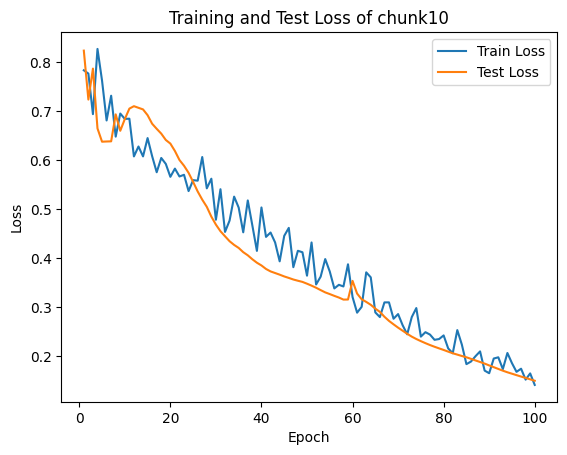

In [ ]:
# 이제 학습 손실과 테스트 손실을 시각화할 수 있습니다.
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss of chunk10')
plt.legend()
plt.show()


In [ ]:
#ROC train_predictiond이 0이 나오는 이유....?